<a href="https://colab.research.google.com/github/MahdiEsrafili/image_segmentation/blob/master/Segmentation_Drone_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

In [2]:
! mkdir ~/.kaggle
% cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d bulentsiyah/semantic-drone-dataset
!unzip -q semantic-drone-dataset.zip -d data/

100% 3.89G/3.89G [01:14<00:00, 43.6MB/s]
100% 3.89G/3.89G [01:14<00:00, 56.3MB/s]


In [3]:
!git clone https://github.com/MahdiEsrafili/SegLoss.git

Cloning into 'SegLoss'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 339 (delta 0), reused 3 (delta 0), pack-reused 334
Receiving objects: 100% (339/339), 375.41 KiB | 18.77 MiB/s, done.
Resolving deltas: 100% (157/157), done.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

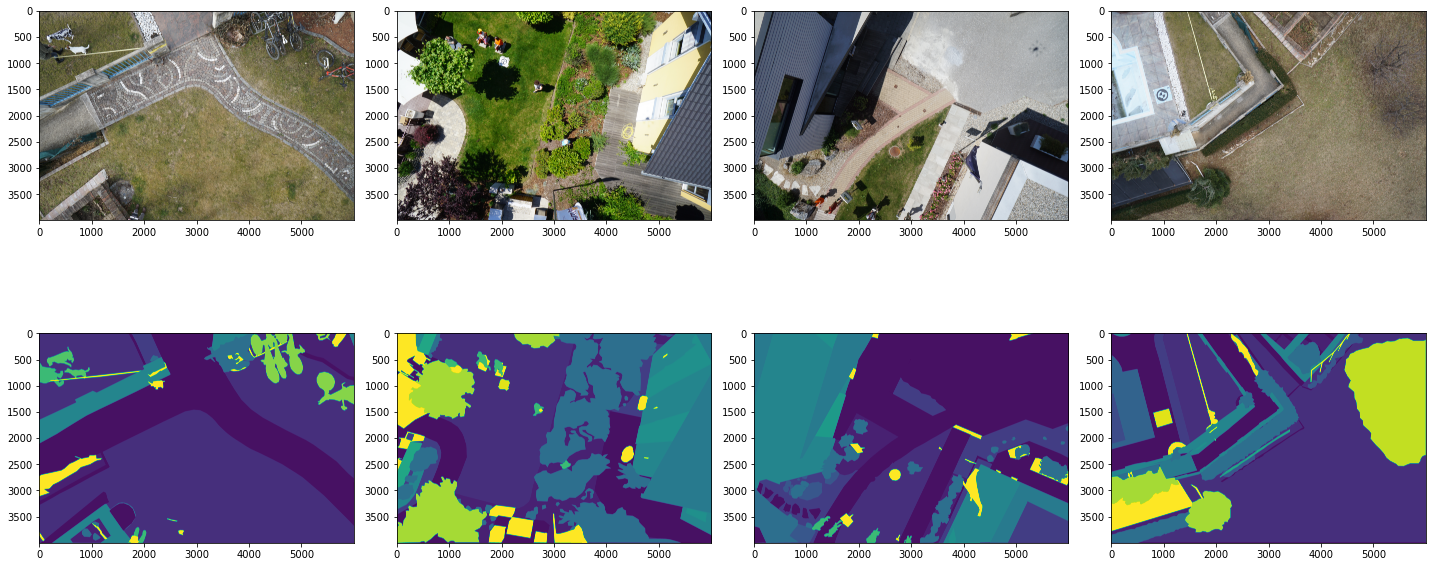

In [2]:
path = 'data/dataset/semantic_drone_dataset'
files = os.listdir(os.path.join(path, 'original_images'))
random_selected = np.random.choice(files, size=4, replace=False)
plt.figure(figsize=(20, 10))
for i, f in enumerate(random_selected):
  img = Image.open(os.path.join(path, 'original_images', f))
  img_id = f.split('.')[0]
  label = Image.open(os.path.join(path, 'label_images_semantic', f'{img_id}.png'))
  plt.subplot(2,4,i+1)
  plt.imshow(img)
  plt.subplot(2,4, 4+i+1)
  plt.imshow(label)

plt.tight_layout()

In [5]:
import torch
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from tqdm.notebook import tqdm

In [6]:
class DroneDS(Dataset):
  def __init__(self, img_path, label_path, transforms, size=512):
    self.img_path = img_path
    self.label_path = label_path
    self.transforms = transforms
    self.ids = self.get_ids()
    self.size = size

  def __len__(self):
    return len(os.listdir(self.img_path))

  def get_ids(self):
    files = os.listdir(self.img_path)
    ids = [x.split('.')[0] for x in files]
    return ids

  def crop(self, img, label):
    h, w = label.shape
    x_min = np.random.randint(0, w-self.size)
    y_min = np.random.randint(0, h-self.size)
    x_max= x_min + self.size
    y_max = y_min + self.size
    img = img[:, y_min:y_max, x_min:x_max]
    label = label[y_min:y_max, x_min:x_max]
    return img, label
    
  def __getitem__(self, id):
    img = Image.open(os.path.join(self.img_path, f'{self.ids[id]}.jpg'))
    label = Image.open(os.path.join(self.label_path, f'{self.ids[id]}.png'))
    img = self.transforms['image'](img)
    label = self.transforms['label'](label)
    label = np.array(label)
    label = torch.tensor(label)
    # img, label = self.crop(img, label)
    return img, label
    


In [7]:
img_transforms = T.Compose([T.Resize((512, 512)), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
label_transforms = T.Compose([T.Resize((512, 512))])
transforms= {'image':img_transforms, 'label':label_transforms}

In [8]:
img_path = 'data/dataset/semantic_drone_dataset/original_images'
label_path = 'data/dataset/semantic_drone_dataset/label_images_semantic'
drone_ds = DroneDS(img_path, label_path, transforms)

In [14]:
train_dataset, test_dataset = torch.utils.data.random_split(drone_ds, [80,320])
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [15]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
unnormalizer = UnNormalize(mean, std)

In [28]:
def train(model, optimizer, criterion, lr_scheduler, loaders, epochs=10):
  loss_history = []
  for epoch in range(epochs):
    model = model.train()
    pbar = tqdm(loaders['train_loader'])
    epoch_loss = np.array([])
    for images, labels in pbar:
      images = images.to(device).float()
      labels = labels.to(device).long()
      optimizer.zero_grad()
      out = model(images)
      loss = criterion(out['out'], labels)
      loss.backward()
      optimizer.step()
      epoch_loss = np.append(epoch_loss, loss.item())
      pbar.set_description(f'epoch {epoch+1}/{epochs}, loss= {epoch_loss.mean():.5f}')
    
    loss_history.append(epoch_loss.mean())
    lr_scheduler.step()
    with torch.no_grad():
      model.eval()
      test_samples = next(iter(loaders['test_loader']))
      out = model(test_samples[0].to(device).float())
      plt.figure(figsize=(15,5))
      plt.subplot(1,3,1)
      plt.imshow(unnormalizer(test_samples[0][0].cpu()).permute(1,2,0))
      plt.title('image')
      plt.subplot(1,3,2)
      plt.imshow(test_samples[1][0].cpu())
      plt.title('ground truth')
      plt.subplot(1,3,3)
      plt.imshow(out['out'][0].permute(1,2,0).cpu().argmax(dim=2))
      plt.title('predicted mask')
      plt.show()
  return model, loss_history

In [29]:

from SegLoss.losses_pytorch import dice_loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = models.segmentation.deeplabv3_resnet50(pretrained=True, progress=True)
model.classifier = models.segmentation.deeplabv3.DeepLabHead(2048, 23)
model = model.to(device)
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)
# criterion = dice_loss.SoftDiceLoss()
criterion = torch.nn.CrossEntropyLoss()
loaders = {'train_loader':train_loader, 'test_loader':test_loader}

cuda


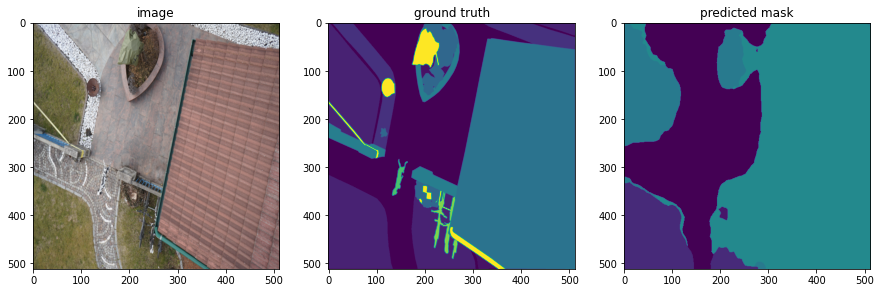

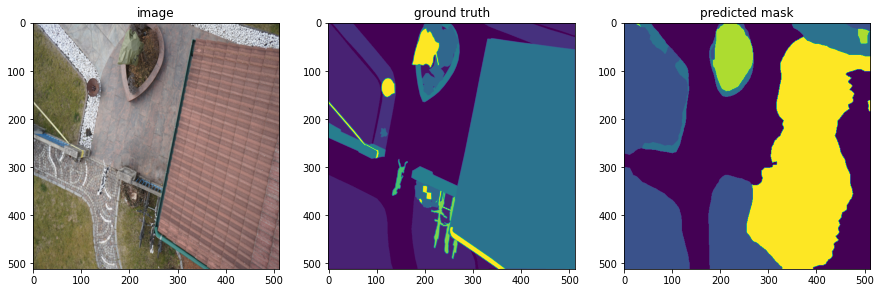

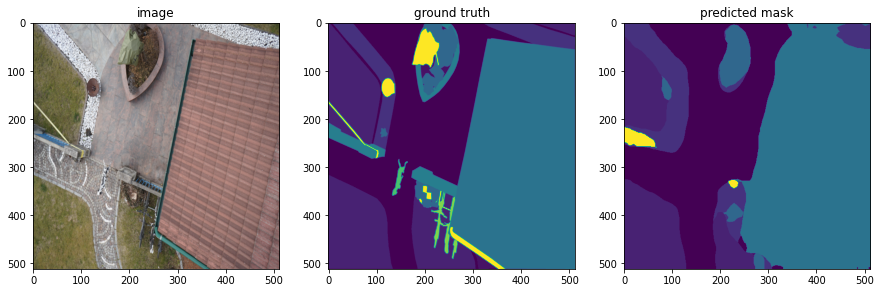

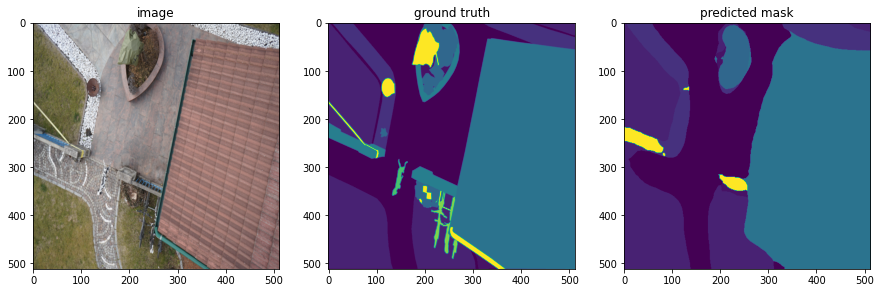

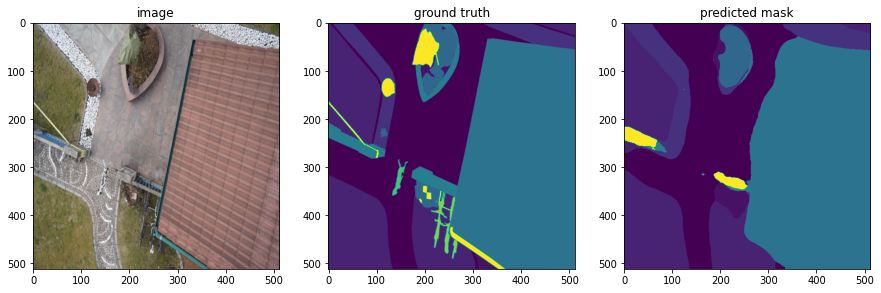

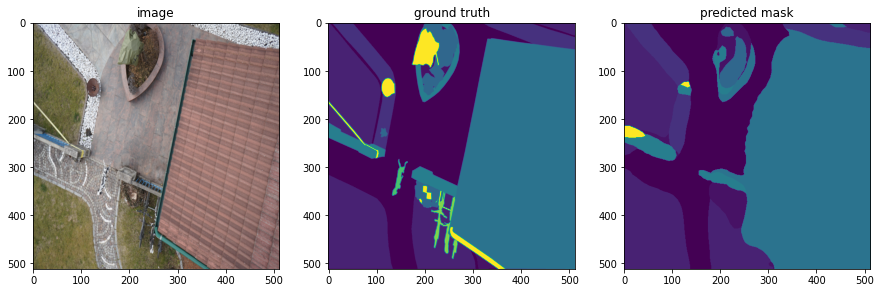

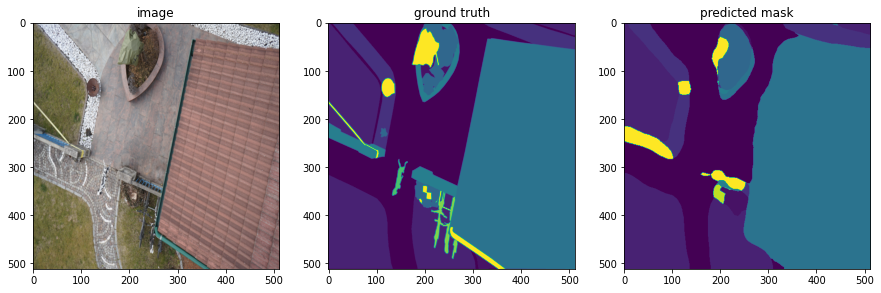

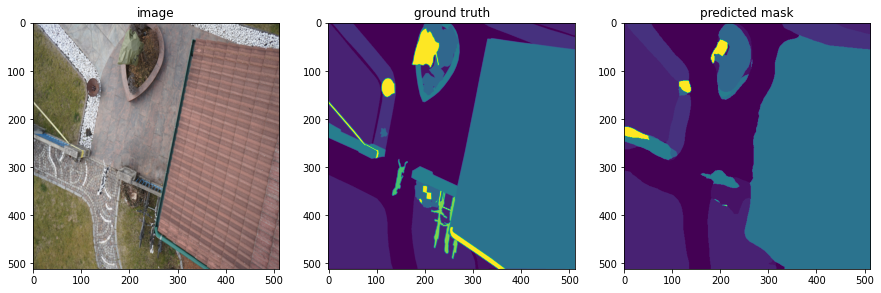

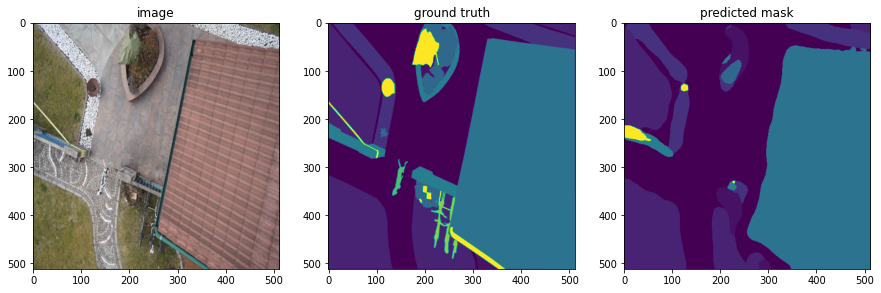

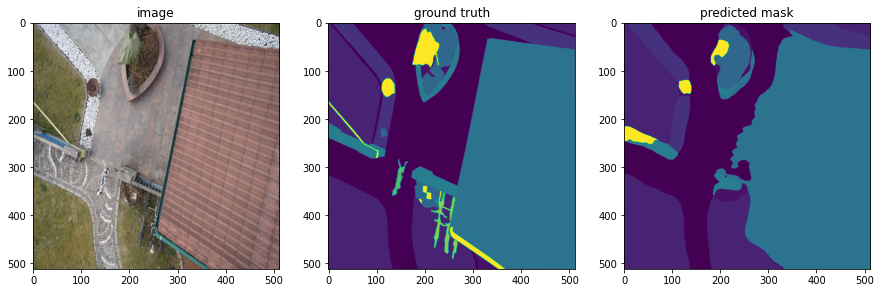

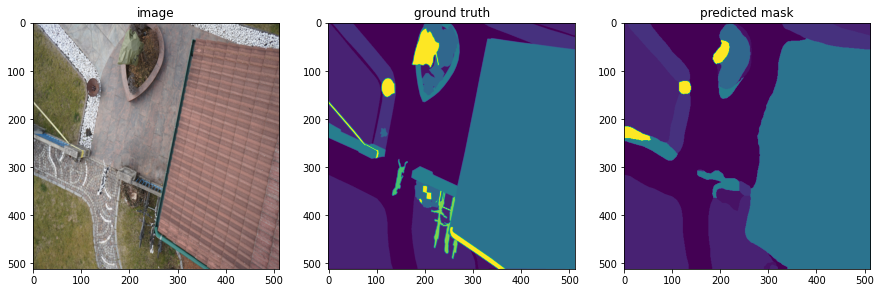

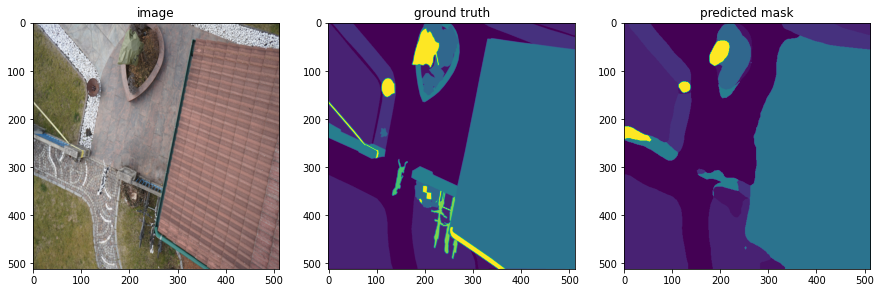

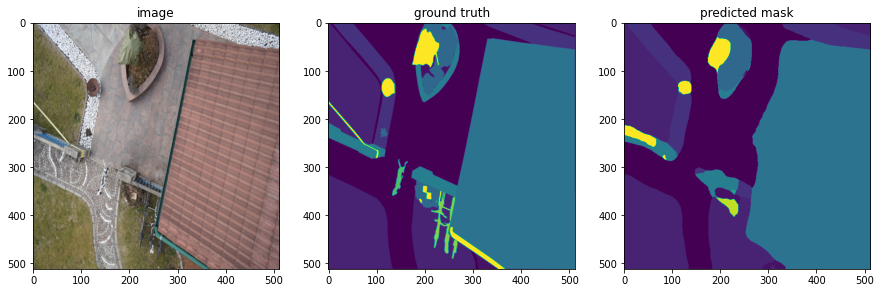

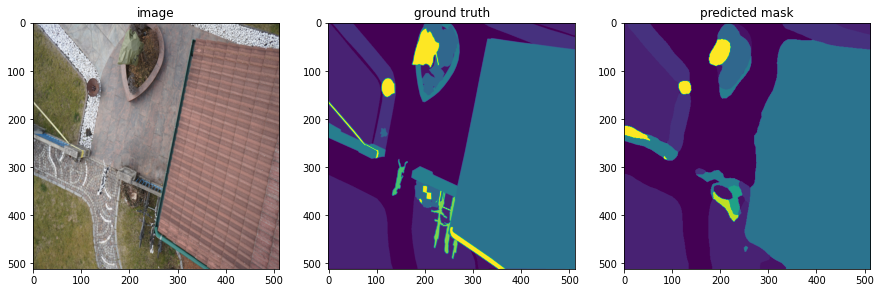

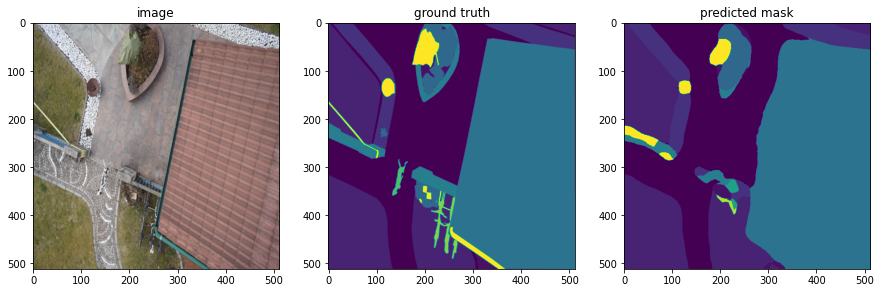

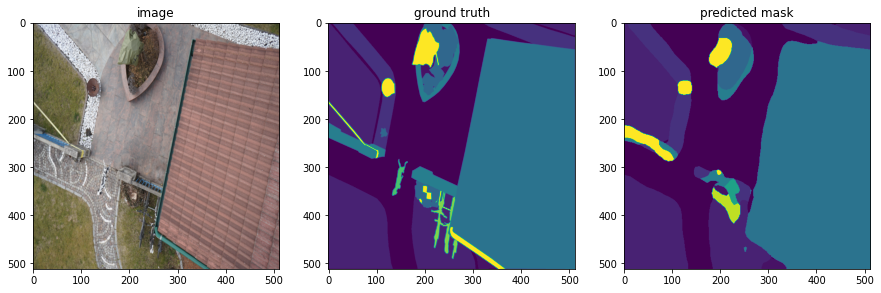

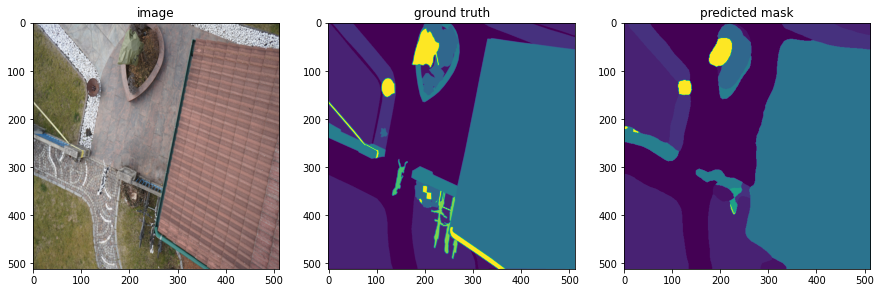

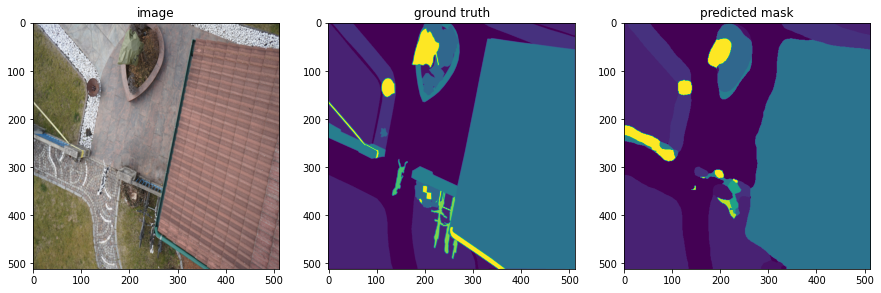

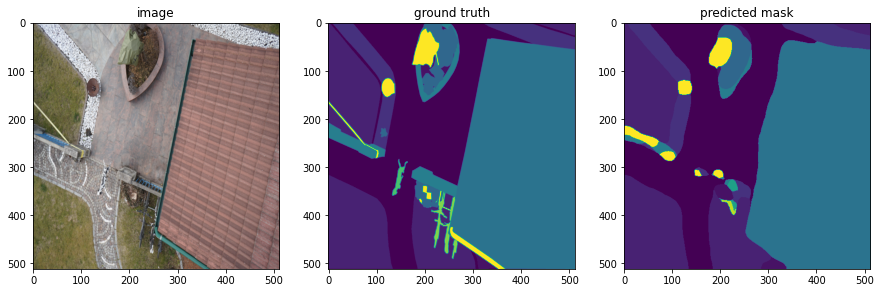

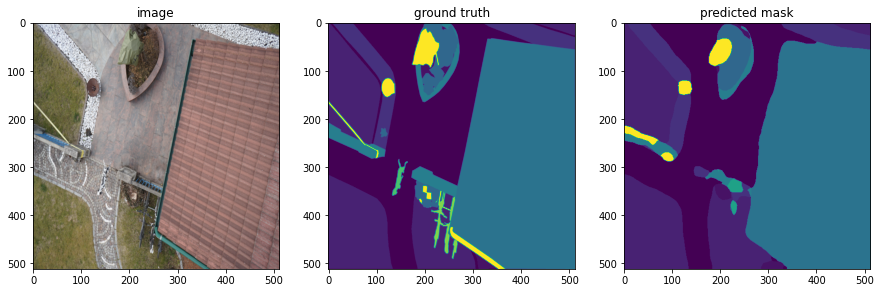

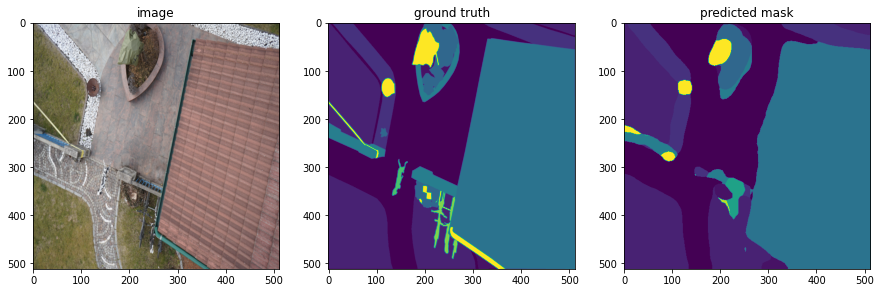

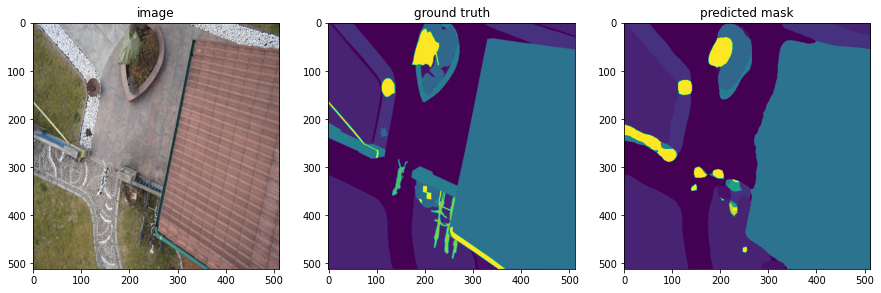

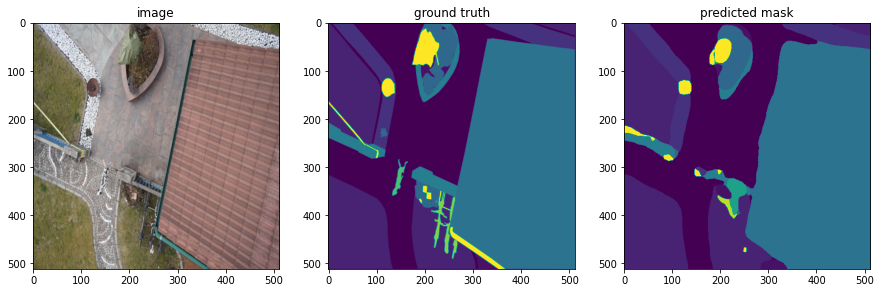

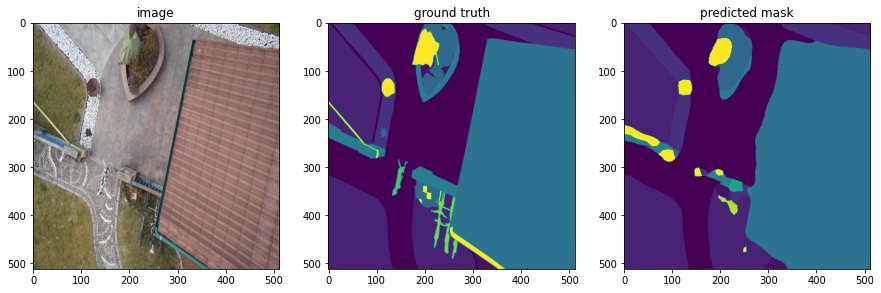

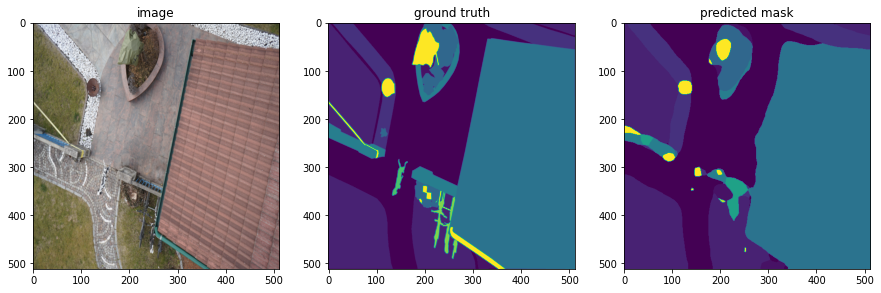

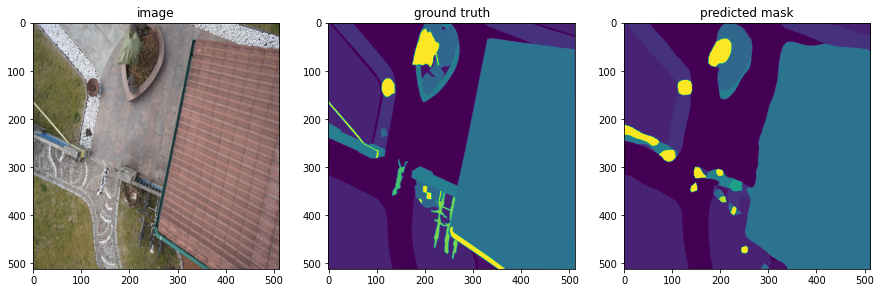

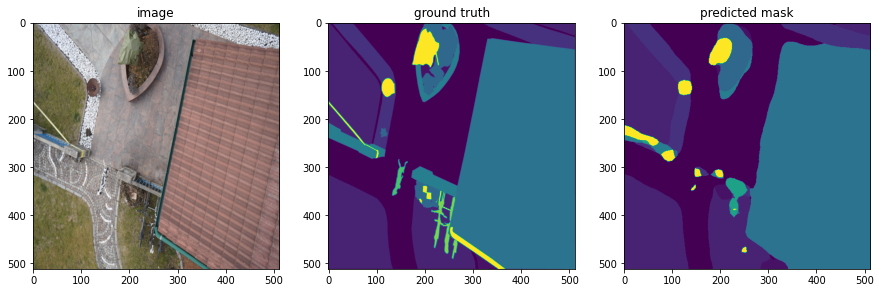

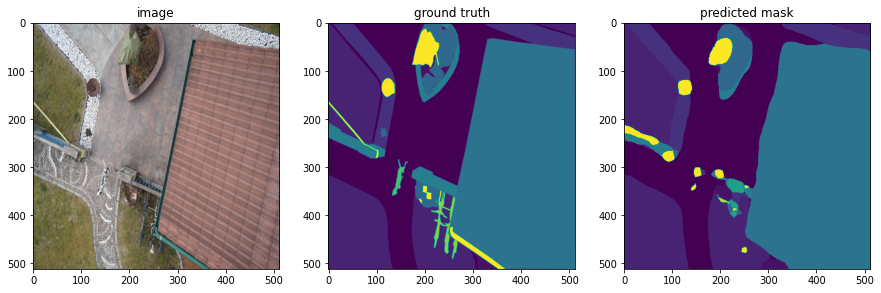

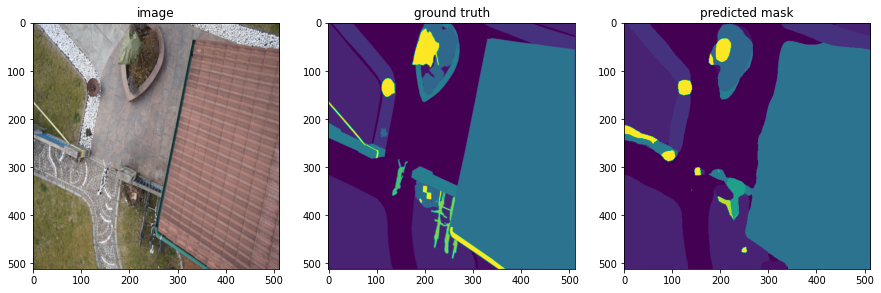

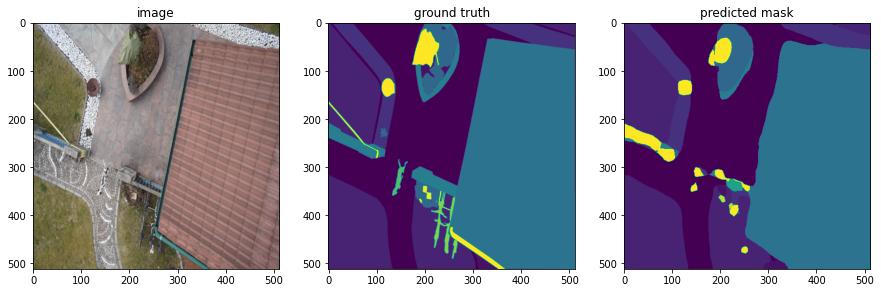

In [30]:
model, loss_history = train(model, optimizer, criterion, lr_scheduler, loaders, epochs=30)

In [31]:
with open('model_multi_class.pt', 'wb') as f:
  torch.save(model, f)
!cp model_multi_class.pt drive/MyDrive/aerial_image_segmentation/

In [37]:
def test(test_loader):
  with torch.no_grad():
    model.eval()
    test_losses = []
    preds = []
    ground_truth = []
    original_images = []
    for images, labels in test_loader:
      images = images.to(device).float()
      labels = labels.to(device).long()
      out = model(images)
      ground_truth.append(labels)
      original_images.append(images)
      loss = criterion(out['out'], labels)
      preds.append(out['out'].cpu())
      test_losses.append(loss.item())
    print(f'test loss: {sum(test_losses)/len(test_losses):.5f}')
  return original_images, ground_truth, preds

In [38]:
original_images, ground_truth, preds = test(test_loader)

test loss: 0.70350


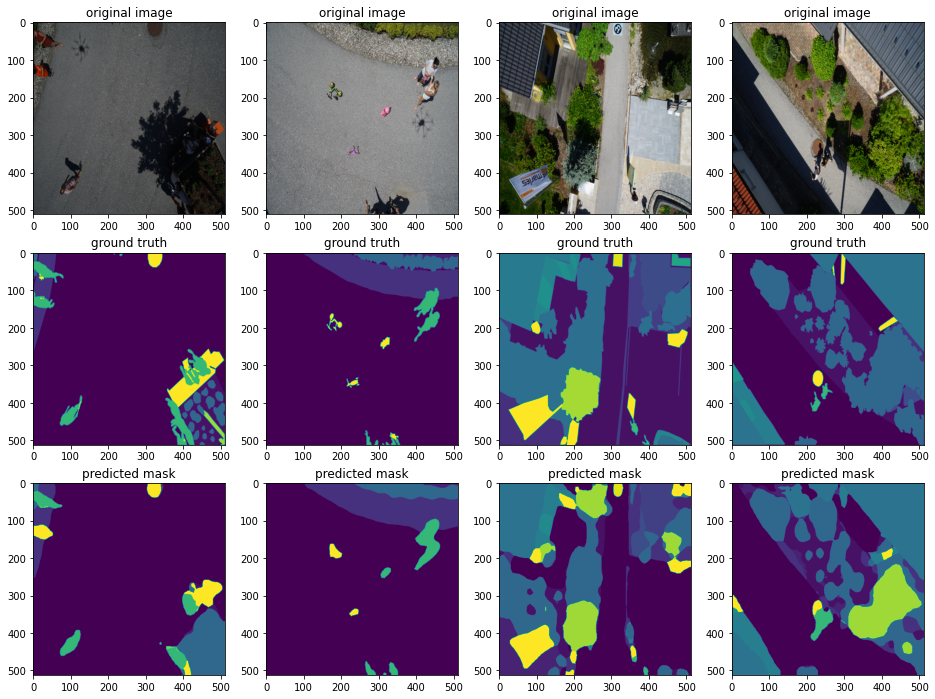

<Figure size 432x288 with 0 Axes>

In [39]:
plt.figure(figsize=(16,12))
for n, b in enumerate(np.random.randint(0, len(original_images), 4)):
  i = np.random.randint(0,4)
  img = unnormalizer(original_images[b][i].cpu()).permute(1,2,0)
  gt = ground_truth[b][i].cpu()
  pred = preds[b][i].cpu().argmax(dim=0)
  plt.subplot(3,4,n+1)
  plt.imshow(img)
  plt.title('original image')
  plt.subplot(3,4,4+n+1)
  plt.imshow(gt)
  plt.title('ground truth')
  plt.subplot(3,4,8+n+1)
  plt.imshow(pred)
  plt.title('predicted mask')

plt.show()
plt.tight_layout()

In [ ]:
#TODO: check result with metrics